# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import re

from tqdm.auto import tqdm

C:\Users\hueso\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
#%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('C:/Users/hueso/Nextcloud/Personal_L/Tripleten/Course/Sprint_16/Files/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()
df_reviews.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
34668,tt0460721,movie,The Big Bad Swim,The Big Bad Swim,2006,\N,96,0,"Comedy,Romance,Sport",6.3,1396,I had the opportunity to see this film twice a...,10,pos,1,train,1943
20220,tt0085426,movie,Le Dernier Combat (The Last Battle),Le dernier combat,1983,\N,92,0,Sci-Fi,6.8,5463,"Although compared with ""Mad Max"", this film is...",10,pos,1,test,3719
44053,tt0103112,movie,Toy Soldiers,Toy Soldiers,1991,\N,111,0,"Action,Drama,Thriller",6.6,19120,This is one of those movies that are very unde...,9,pos,1,test,11938
21720,tt0327036,movie,Martin Lawrence Live: Runteldat,Martin Lawrence Live: Runteldat,2002,\N,113,0,"Comedy,Documentary",5.4,1615,I usually really like Lawrence and being in Au...,1,neg,0,test,9287
42518,tt0144183,movie,The Unfrocked One,Le défroqué,1954,\N,107,0,Drama,5.8,102,There are some comments about this film that s...,10,pos,1,train,4764


In [6]:
print(df_reviews.describe())

         start_year      is_adult  average_rating         votes        rating  \
count  47331.000000  47331.000000    47329.000000       47329.0  47331.000000   
mean    1989.631235      0.001732        5.998278  25562.917323      5.484608   
std       19.600364      0.041587        1.494289  83670.039163      3.473109   
min     1894.000000      0.000000        1.400000           9.0      1.000000   
25%     1982.000000      0.000000        5.100000         827.0      2.000000   
50%     1998.000000      0.000000        6.300000        3197.0      4.000000   
75%     2004.000000      0.000000        7.100000       13974.0      9.000000   
max     2010.000000      1.000000        9.700000     1739448.0     10.000000   

                pos           idx  
count  47331.000000  47331.000000  
mean       0.498954   6279.697999  
std        0.500004   3605.702545  
min        0.000000      0.000000  
25%        0.000000   3162.000000  
50%        0.000000   6299.000000  
75%        1.00000

In [7]:
df_reviews = df_reviews.dropna()
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     0
votes              0
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Lo que puedo notar es que los datos vienen en los tipos de datos correctos. Solo dos valores estaban faltantes, pero decidí borrarlos ya que son muy pocos datos y no afecta quitarlos. Tambien puedo notar que el año de inicio de las peliculas reseñadas es de 1894 al 2010. La columna "avarage_rating" va del 1 al 10. Y por ultimo que todo el DF se compone de 47329 observaciones y que hay una columna especifica para decirnos si es una observacion de parte del train o del test, esto nos ayudará mas adelante al momento de hacer el split.

## EDA (Exploratory Data Analysis)

Veamos el número de películas y reseñas a lo largo de los años.

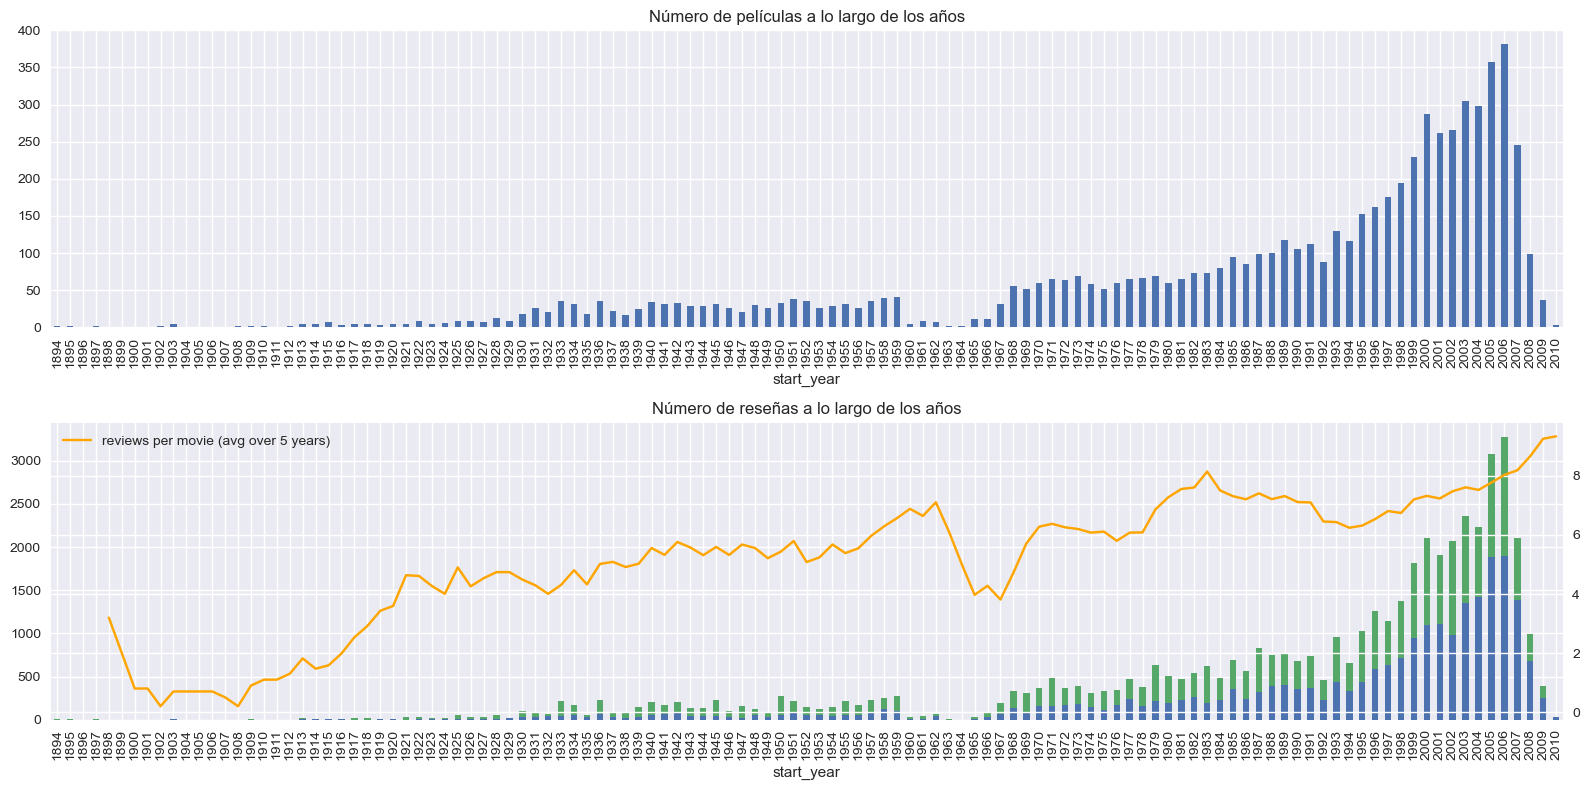

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2011))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2011))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2011))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

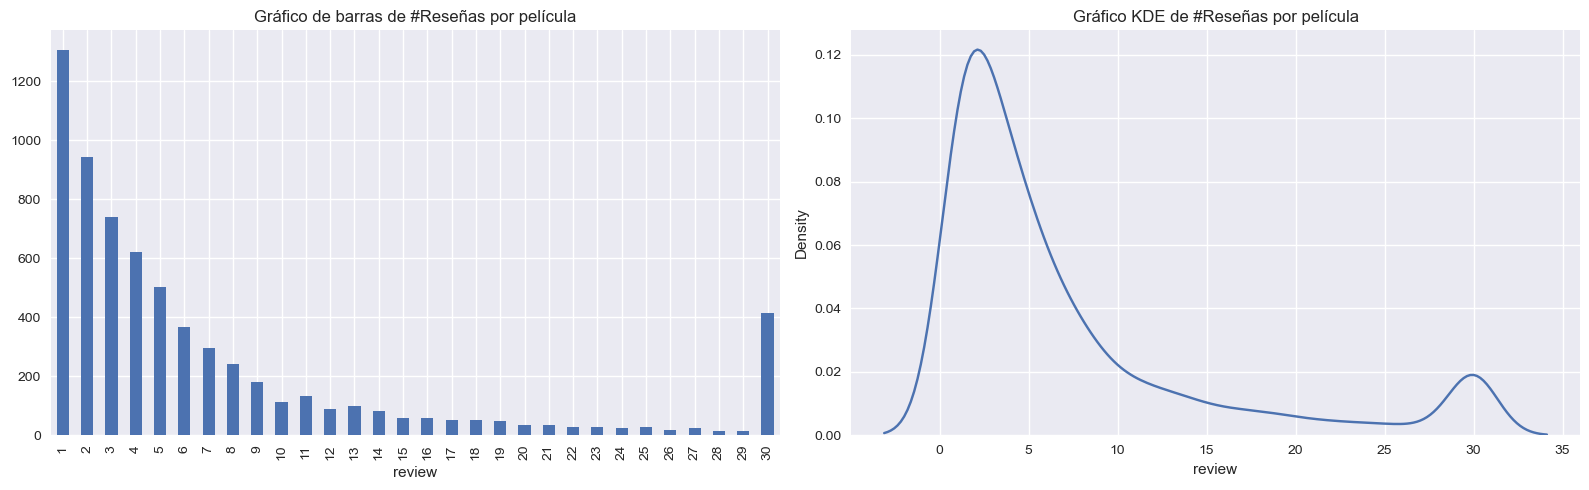

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La mayoria de las peliculas cuentan con solo una reseña, pero la media de las reseñas radica en 3. Esto hace que la distribución esté sesgada hacia la derecha, ya que hay unas cuantas peliculas con más de 30 reseñas.

In [10]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23614
Name: count, dtype: int64

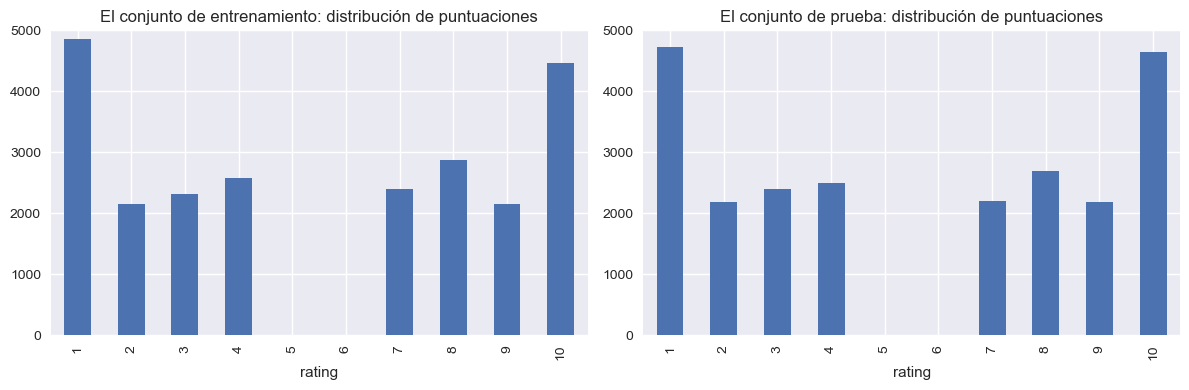

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

La distribucion de las reseñas tanto en el conjunto de entrenamiento como en el de prueba está casi igual, eso es bueno para entrenar el modelo.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\hueso\AppData\Local\Temp\ipykernel_33932\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\hueso\AppData\Local\Temp\ipykernel_33932\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\hueso\AppData\Local\Temp\ipykernel_33932\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\hueso\AppData\Local\Temp\ipykernel_33932\1324160450.py:31: UserWarning: 

Support for a

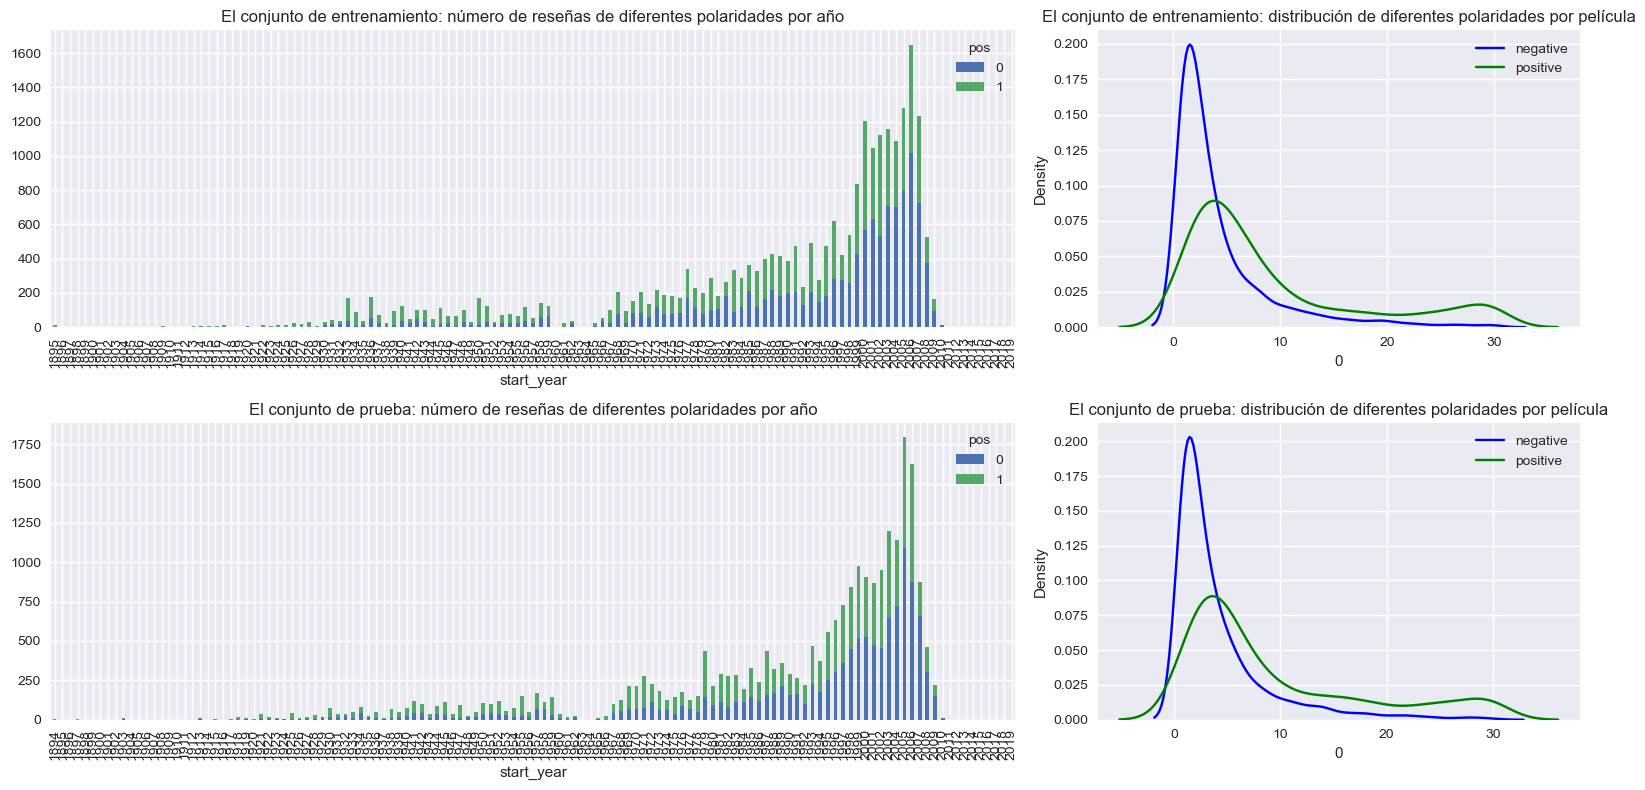

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

En conclusión lo que puedo observar es:

*A partir de 1965 es que incrementó el numero de peliculas y por consiguiente el número de reseñas.

*La mayoria de las peliculas cuentan con solo una reseña, pero la media de las reseñas radica en 3. Esto hace que la distribución esté sesgada hacia la derecha, ya que hay unas cuantas peliculas con más de 30 reseñas.

*La distribucion de las reseñas tanto en el conjunto de entrenamiento como en el de prueba está casi igual, eso es bueno para entrenar el modelo. Es curioso que los extremos sean los más elegidos (1 y 10) mientras que las calificaciones centrales casi no se eligen (5 y 6)

*Entre el conjunto de entrenamiento y el de prueba podemos observar que las reseñas que se consideran positivas y las que se consideran negativas estan distribuidas al parecer en un 50-50 ya que ambas gráficas lucen casi iguales.


## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [13]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [14]:
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x:x.lower())
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x:re.sub(r'[^a-zA-z\']', ' ', x))
df_reviews['review_norm'] = df_reviews['review_norm'].apply(lambda x:" ".join(x.split()))


In [15]:
df_reviews['review_norm'].sample(1)

45489    the first full length film featuring the aardm...
Name: review_norm, dtype: object

## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

features_train = df_reviews_train.drop(['pos'], axis=1)
features_test = df_reviews_test.drop(['pos'], axis=1)

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

print(features_train.shape)
print(features_test.shape)

(23796, 17)
(23533, 17)


## Trabajar con modelos

### Modelo 0 - Constante | Baseline | Cordura

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


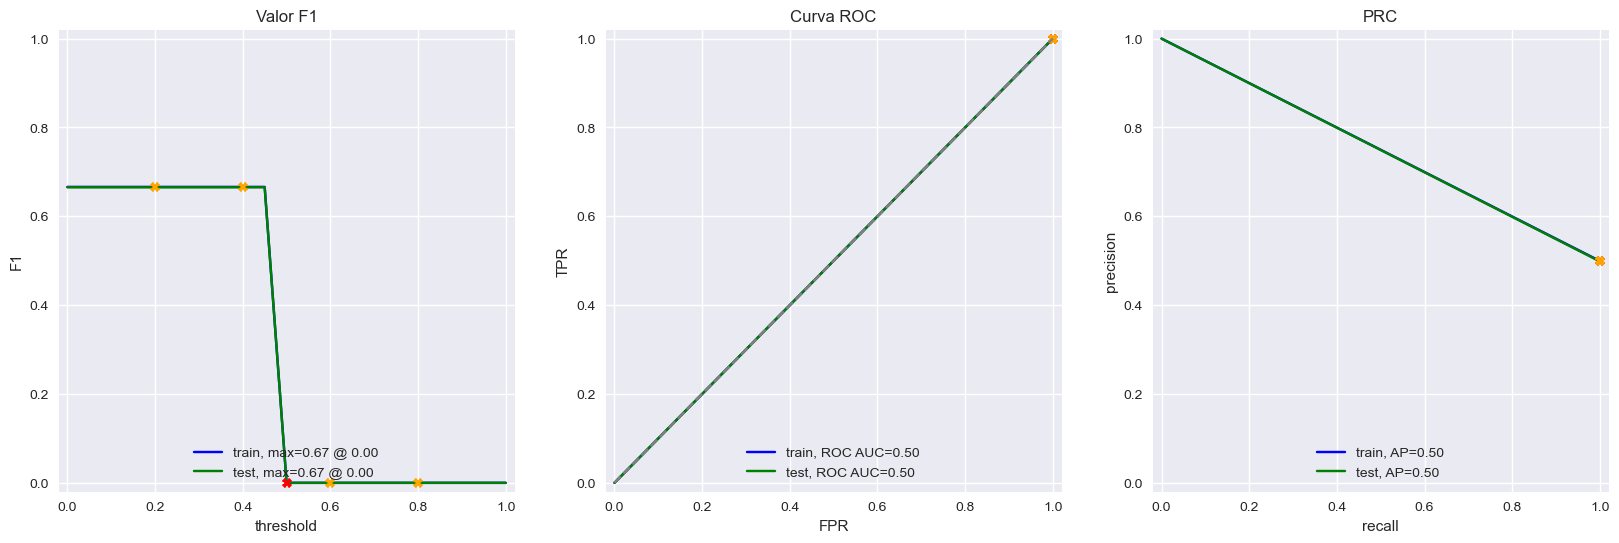

In [17]:
from sklearn.dummy import DummyClassifier
model_constant = DummyClassifier()
model_constant.fit(features_train,target_train)
evaluate_model(model_constant,features_train,target_train,features_test,target_test)

### Modelo 1 - NLTK, TF-IDF y LR (Logistic Regression)

TF-IDF

In [18]:
import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hueso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: total: 3.83 s
Wall time: 3.93 s


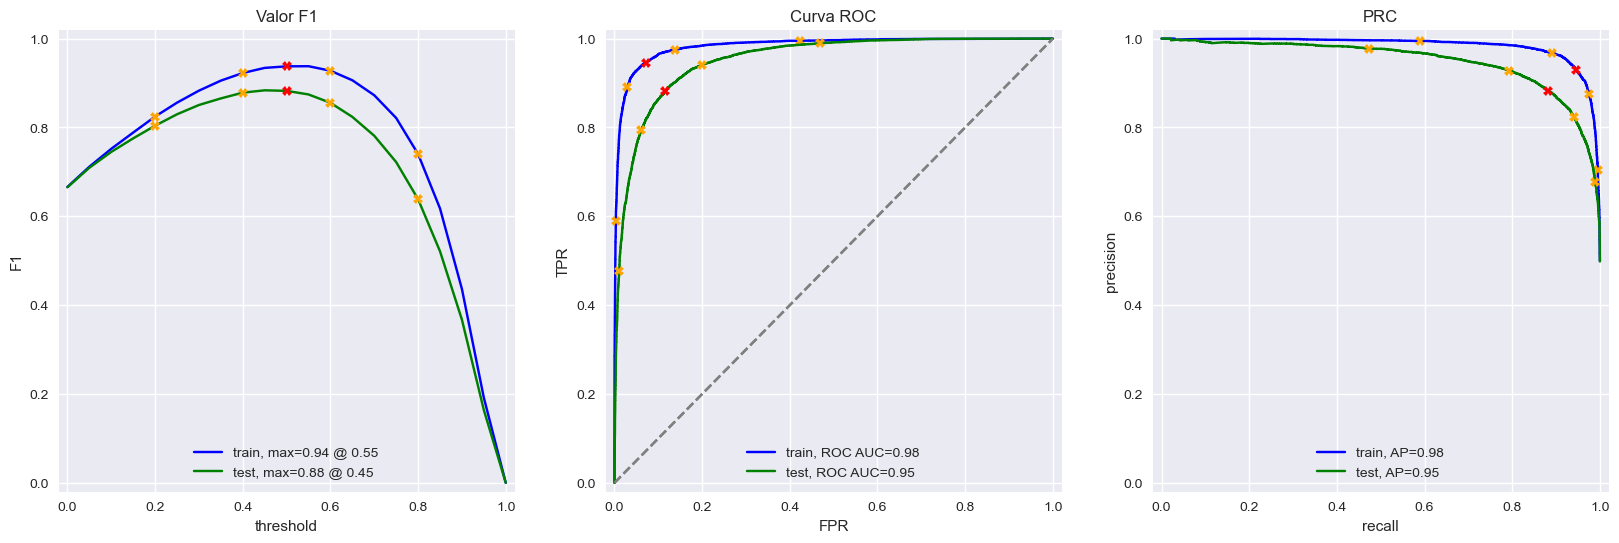

In [19]:
%%time
corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']
target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

stop_words = stopwords.words('english')
tf_idf_vect_1= TfidfVectorizer(stop_words=stop_words)

features_train = tf_idf_vect_1.fit_transform(corpus_train)

model_lr = LogisticRegression(solver='liblinear',random_state=123)
model_lr.fit(features_train,target_train)

features_test = tf_idf_vect_1.transform(corpus_test)
predictions = model_lr.predict(features_test)

#funcion de evaluación
evaluate_model(model_lr, features_train, target_train, features_test, target_test)

Este modelo tiene un score f1 en el set de prueba de 0.88, lo que lo hace un buen modelo para predecir si la reseña es positiva o negativa.

### Modelo 2 - spaCy, TF-IDF y LR

In [20]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [21]:
def text_preprocessing_1(text,n_process=-1,batch_size=1000):

    docs = nlp.pipe(text,n_process=n_process,batch_size=batch_size)
    for doc in docs:
        tokens = [token.lemma_ for token in doc]
        yield ' '.join(tokens)

In [22]:
%%time
# Lemmatize df_reviews['review_norm']
#df_reviews['review_lemm'] = df_reviews['review_norm'].apply(text_preprocessing_1)

df_reviews['review_lemm'] = list(text_preprocessing_1(df_reviews['review_norm']))

CPU times: total: 1min 10s
Wall time: 2min 6s


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95
CPU times: total: 4.05 s
Wall time: 4.21 s


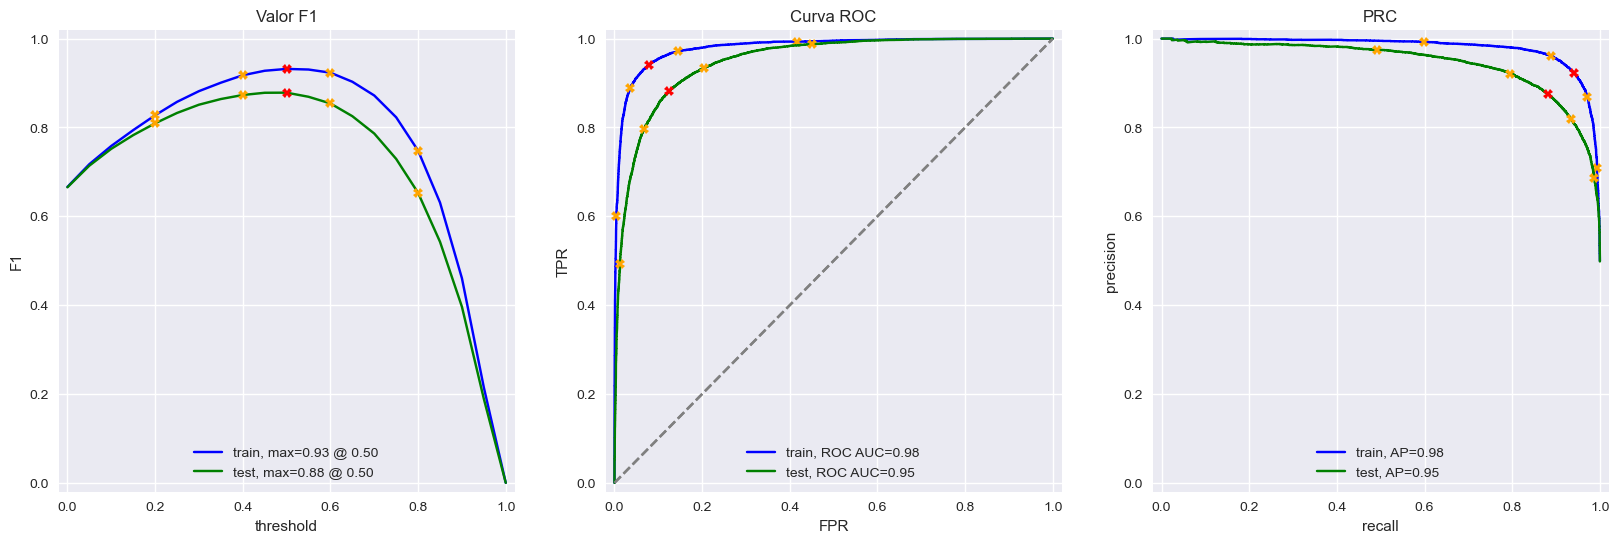

In [23]:
%%time
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()
corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']
target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

stop_words = stopwords.words('english')
tf_idf_vect_2 = TfidfVectorizer(stop_words=stop_words)

features_train = tf_idf_vect_2.fit_transform(corpus_train)

model_spacy_lr = LogisticRegression(solver='liblinear',random_state=123)
model_spacy_lr.fit(features_train,target_train)

features_test = tf_idf_vect_2.transform(corpus_test)
predictions = model_spacy_lr.predict(features_test)

#funcion de evaluación
evaluate_model(model_spacy_lr, features_train, target_train, features_test, target_test)



Este modelo tiene un score f1 en el set de prueba de 0.88, lo que lo hace un buen modelo para predecir si la reseña es positiva o negativa.

### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [24]:
from lightgbm import LGBMClassifier


[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.147517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455394
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9352
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353


c:\ProgramData\anaconda3\envs\tripleenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\tripleenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\tripleenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\tripleenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\ProgramData\anaconda3\envs\tripleenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fit

          train  test
Accuracy   0.91  0.86
F1         0.92  0.86
APS        0.97  0.93
ROC AUC    0.97  0.94
CPU times: total: 1min 32s
Wall time: 11.1 s


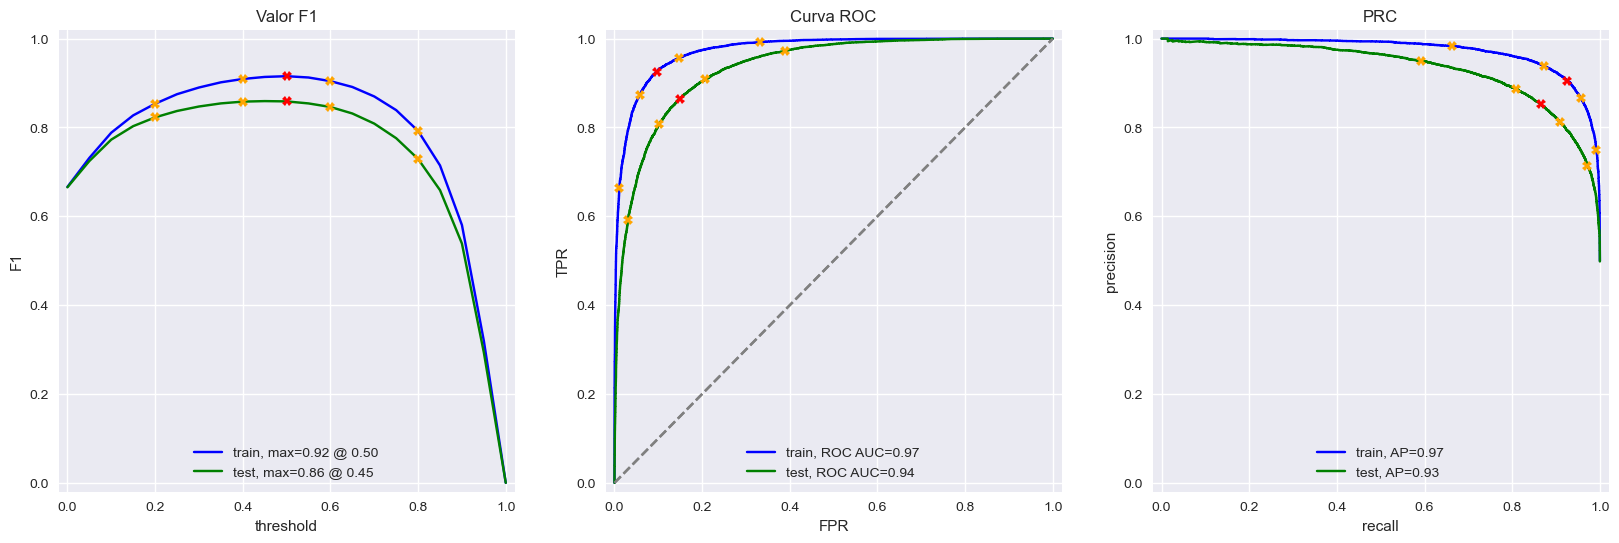

In [25]:
%%time
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()
corpus_train = df_reviews_train['review_lemm']
corpus_test = df_reviews_test['review_lemm']
target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

stop_words = stopwords.words('english')
tf_idf_vect_3 = TfidfVectorizer(stop_words=stop_words)

features_train = tf_idf_vect_3.fit_transform(corpus_train)

model_lgbm = LGBMClassifier(random_state=123)
model_lgbm.fit(features_train,target_train)

features_test = tf_idf_vect_3.transform(corpus_test)
predictions = model_lgbm.predict(features_test)

#funcion de evaluación
evaluate_model(model_lgbm, features_train, target_train, features_test, target_test)

Este modelo tiene un score f1 en el set de prueba de 0.86, lo que lo hace un buen modelo para predecir si la reseña es positiva o negativa.

###  Modelo 4 - BERT, LR

In [26]:
import torch
import transformers

In [27]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (f"Usando dispositivo: {device}")
model.to(device)
model.eval()

Usando dispositivo: cuda


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [28]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=64, disable_progress_bar=False):
    embeddings = []

    encodings = tokenizer(list(texts),padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

    input_ids = encodings["input_ids"]
    attention_masks = encodings["attention_mask"]

    for i in tqdm(range(math.ceil(len(input_ids) / batch_size)), disable=disable_progress_bar):
        ids_batch = input_ids[batch_size*i : batch_size*(i+1)].to(device)
        mask_batch = attention_masks[batch_size*i : batch_size*(i+1)].to(device)

        with torch.no_grad():
            outputs = model(input_ids=ids_batch, attention_mask=mask_batch)
        
        batch_embeddings = outputs.last_hidden_state[:, 0, :]

        embeddings.append(batch_embeddings.cpu().numpy())

    return np.concatenate(embeddings)

In [29]:
%%time
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

corpus_train = df_reviews_train['review_norm']
corpus_test = df_reviews_test['review_norm']

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

features_train = BERT_text_to_embeddings(corpus_train, batch_size=64)
features_test = BERT_text_to_embeddings(corpus_test, batch_size=64)

print("Train embeddings shape:", features_train.shape)
print("Test embeddings shape:", features_test.shape)

100%|██████████| 368/368 [01:09<00:00,  5.28it/s]

Train embeddings shape: (23796, 768)
Test embeddings shape: (23533, 768)
CPU times: total: 4min 29s
Wall time: 4min 34s


          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


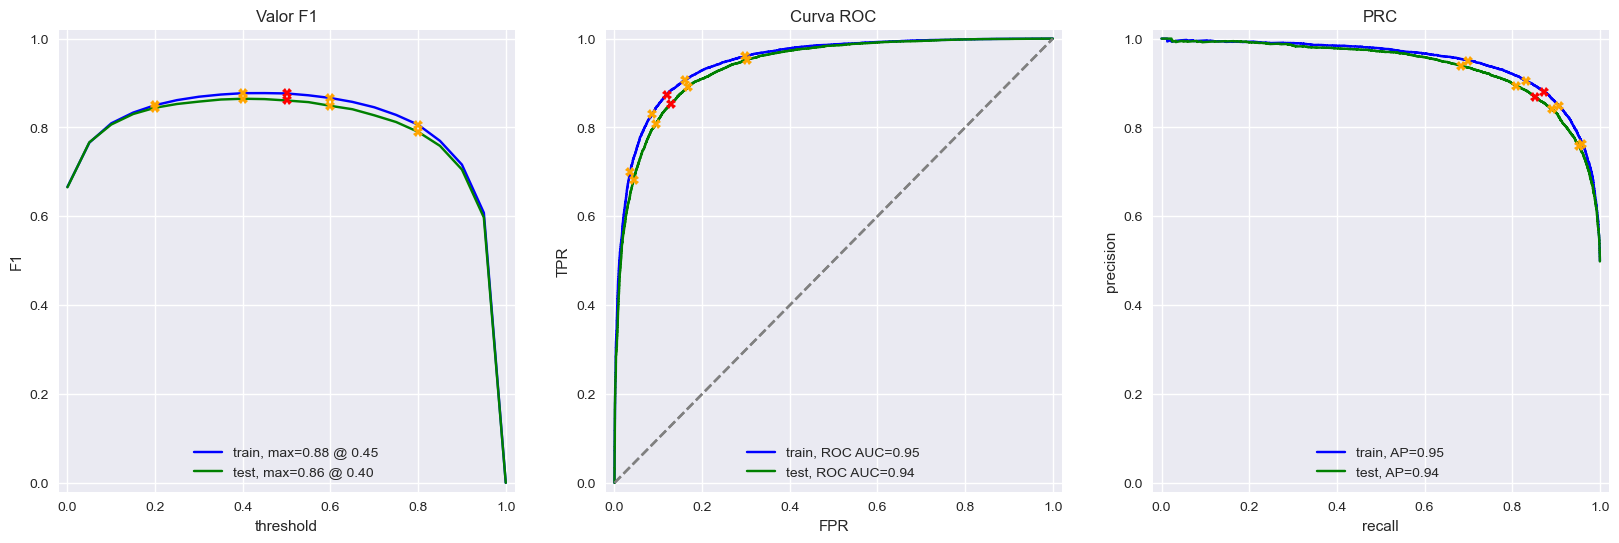

In [30]:
model_bert_logr = LogisticRegression(solver='liblinear',random_state=123,max_iter=1000)
model_bert_logr.fit(features_train,target_train)
predictions = model_bert_logr.predict(features_test)

#funcion de evaluación
evaluate_model(model_bert_logr, features_train, target_train, features_test, target_test)

Observando los resultados y tiempos de los diferentes modelos podemos ver que el modelo 1 (NLTK, TF-IDF, LR) y 2 (spaCy, TF-IDF, LR) obtuvieron un score de f1 de 0.88 en el set de prueba. Además de que fueron bastante rápidas. Por otro lado el modelo 4 es considerablemente más tardado con un score F1 de 0.86.

## Mis reseñas

In [31]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: " ".join(re.sub(r'[^A-Za-z]', ' ', x.lower()).split()))

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn t expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...


### Modelo 1 - NLTK, TF-IDF y LR (Logistic Regression)

In [32]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr.predict_proba(tf_idf_vect_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn t expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 2 - spaCy, TF-IDF y LR

In [44]:
texts = my_reviews['review_norm']
texts_lemm=list(text_preprocessing_1(texts))
my_reviews_pred_prob = model_spacy_lr.predict_proba(tf_idf_vect_2.transform(texts_lemm))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.13:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.27:  i didn t expect the reboot to be so good writers really cared about the source material
0.50:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.92:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [45]:
texts = my_reviews['review_norm']
texts_lemm=list(text_preprocessing_1(texts))

tfidf_vectorizer_4 = tf_idf_vect_3
my_reviews_pred_prob = model_lgbm.predict_proba(tfidf_vectorizer_4.transform(texts_lemm))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.57:  i did not simply like it not my kind of movie
0.38:  well i was bored and felt asleep in the middle of the movie
0.58:  i was really fascinated with the movie
0.38:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.68:  i didn t expect the reboot to be so good writers really cared about the source material
0.71:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.32:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.76:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


c:\ProgramData\anaconda3\envs\tripleenv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


###  Modelo 4 - BERT, LR

In [47]:
texts = my_reviews['review_norm']

my_reviews_features = BERT_text_to_embeddings(texts, batch_size=64)

my_reviews_pred_prob = model_bert_logr.predict_proba(my_reviews_features)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

0.24:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.17:  i didn t expect the reboot to be so good writers really cared about the source material
0.94:  the movie had its upsides and downsides but i feel like overall it s a decent flick i could see myse
0.09:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


## Conclusiones

Todos los modelos obtuvieron un score f1 mayor a 0.85 lo que es bastante bueno, sin embargo el tiempo que toma cada uno es muy diferente. 
Ya tomando en cuenta con nuestras reseñas podemos revisarlas con un "ojo humano" y decir que el modelo 1 nos arroja 2 reseñas mal categorizadas, el modelo 2 nos arroja 1 mal categorizada y una justo a la mitad. El modelo 3 nos arroja 1 mal categorizada. Por ultimo el modelo 4 con BERT nos da un resultado predictivo más hacia los extremos, más cercanos a 0 y 1, nos arrojó una mal categorizada.

Yo recomendaria a Film Junky Union que se use el modelo 3 que es spaCy, TF-IDF y LGBMClassifier y si se tienen más recursos de cómputo BERT con Logistic Regression. Hay que considerar que el modelo BERT considera mucho más contexto de todo el corpus. 

# Lista de comprobación

- [x]  Abriste el notebook
- [x]  Cargaste y preprocesaste los datos de texto para su vectorización
- [x]  Transformaste los datos de texto en vectores
- [x]  Entrenaste y probaste los modelos
- [x]  Se alcanzó el umbral de la métrica
- [x]  Colocaste todas las celdas de código en el orden de su ejecución
- [x]  Puedes ejecutar sin errores todas las celdas de código
- [x]  Hay conclusiones